In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from haversine import haversine, Unit
import itertools
import datetime
from tqdm.notebook import tqdm
pd.set_option('display.max_columns', None)

### Read in DFs and Clean

In [2]:
# new DF with lat-longs from Google Maps
tracks_df = pd.read_excel('../input_data/Nascar -Arca _1980_2020_updated.xlsx')

In [3]:
daily_lead_df = pd.read_csv('../input_data/daily_lead_80_20.csv')

In [4]:
daily_lead_df['point'] = [(x, y) for x,y in zip(daily_lead_df['latitude'], daily_lead_df['longitude'])]

In [5]:
daily_lead_df['date'] = pd.to_datetime(daily_lead_df['date1'])

In [6]:
filt_lead_df = pd.read_pickle("../../21_6_7/notebooks/daily_lead_unique.pkl")

In [7]:
tracks_df['point'] = [(x, y) for x,y in zip(tracks_df['lat_Google_Maps'], tracks_df['long_Google_Maps'])]

In [8]:
tracks_df_4km = tracks_df.copy()
tracks_df_50mi = tracks_df.copy()

### Find All Stations Within X km of Tracks

In [9]:
monitor_points = list(filt_lead_df['point'])
monitor_ids = list(filt_lead_df["monitorID"])

In [10]:
def get_stations_within_thresh(point, points, monitor_ids, distance_thresh_min, distance_thresh_max, dist_unit):
    
    # finds distance between each track and every monitoring station
    dist = []
    if(dist_unit=='km'): # 1 indicates kilometers, else miles
        for p in points:
            x = round(haversine(point, p), 4)
            dist.append(x)
    elif(dist_unit=='mi'):
        for p in points:
            x = round(haversine(point, p, unit=Unit.MILES), 4)
            dist.append(x)
    else:
        raise ValueError('wrong dist unit')
    
    idxs = [i for i,v in enumerate(dist) if (v >= distance_thresh_min and v <= distance_thresh_max)]

    n_smallest_points = [points[idx] for idx in idxs] # monitor coordinates
    n_smallest_ids = [monitor_ids[idx] for idx in idxs] # monitor IDs
    n_smallest_dist = [dist[idx] for idx in idxs]

    return n_smallest_points, n_smallest_ids, n_smallest_dist

In [11]:
def pass_dist_thresh(df, distance_thresh_min, distance_thresh_max, dist_unit):
    df = df.copy()
    df['points_ids_dist'] = [get_stations_within_thresh(x, monitor_points, monitor_ids, distance_thresh_min, distance_thresh_max, dist_unit) 
                                              for x in df['point']]
    dis =''
    if (distance_thresh_max) == 50:
        dis = '50mi'
    elif (distance_thresh_max) == 6:
        dis = '4-6km'
    elif(distance_thresh_max) == 4:
        dis = '4km'
           
    df[f'points_within_{dis}'] = df["points_ids_dist"].apply(lambda x: x[0])
    df['ids'] = df["points_ids_dist"].apply(lambda x: x[1])
    df['distances'] = df["points_ids_dist"].apply(lambda x: x[2])
    df['num_stations'] = [len(x) for x in df[f'points_within_{dis}']]
    
    df = df.query("num_stations != 0").copy()
    df[f'mean ({dist_unit})'] = [round(np.array(x).mean(),4) for x in df['distances'].values]
    df[f'std ({dist_unit})'] = [round(pd.array(x).std(),4) for x in df['distances'].values]
    df[f'max_dist ({dist_unit})'] = [max(x) for x in df['distances']]
    df[f'min_dist ({dist_unit})'] = [min(x) for x in df['distances']]
    
    return df

### Find All Stations Within 4K of Tracks

In [12]:
stations_4km_df = (pass_dist_thresh(tracks_df_4km, 0, 4, 'km')
                                  .drop(['points_ids_dist'], axis=1)
                                  .reset_index(drop=True).copy())

In [13]:
stations_4km_df.to_csv('stations_4km_df.csv')

### Find All Stations Within 50 Miles of Tracks

In [14]:
stations_50mi_df = (pass_dist_thresh(tracks_df_50mi, 0, 50, 'mi')
                                  .drop(['points_ids_dist'], axis=1)
                                  .reset_index(drop=True).copy())
stations_50mi_df['std (mi)'] = stations_50mi_df['std (mi)'].fillna(0)

In [15]:
stations_50mi_df.to_csv('stations_50mi_df.csv')

### Get Avg Pb Readings Pre and Post Races W Distance From Each Monitor to Track (km) 

In [16]:
all_race_dates = pd.read_excel('../input_data/race_dates_4_6.xlsx')

In [17]:
all_race_dates['Date'] = pd.to_datetime(all_race_dates['Date'], errors='coerce')

In [18]:
all_race_dates = all_race_dates.rename(columns = {'Unnamed: 0' : 'Track'})

In [19]:
track_names_04 = ['Autoclub Speedway, CA', 'Chicago Motor Speedway', 'Indiana State Fairgrounds (ARCA)',
'Indianapolis Motor Speedway', 'Kansas Speedway', 'Nazareth','Bristol Speedway',
"Nashville Int'l Raceway/Nashville Fairgrounds Speedway", 'Richmond']

In [20]:
track_names_4km = ['Autoclub Speedway, CA', 'Bristol Speedway', 'Richmond']

In [21]:
def get_tracks(track_names, all_race_dates): 
    race_dates_dfs = []
    for x in track_names:
        df = all_race_dates[all_race_dates['Track']== x].reset_index(drop=True)
        race_dates_dfs.append(df)
    return race_dates_dfs

In [22]:
def readings_pre_post_race(stations_df, daily_lead_df, window, race_date, ids, around):
    if (around == 'pre'):
        mask = (daily_lead_df['date']>= window) & (daily_lead_df['date']< race_date)
    elif (around == 'post'):
        mask = (daily_lead_df['date']>= window) & (daily_lead_df['date']<= race_date)
    else:
        raise ValueError('Wrong Around Type')
    df = daily_lead_df.loc[mask]

    empty = True
    out_ids = []
    out_distances = []
    out_means = []
    out_duplicates = []
    
    duplicate_dict = {}
    
    for ID in ids:
        
        lead_id_df = df[(df['monitorID']==ID)]
        
        if not lead_id_df.empty:
            empty = False
            pb_mean = round(lead_id_df['Pb_mean'].mean(), 5)
            
            idx = ids.index(ID)
            distance_from_track = stations_df['distances'].iloc[0][idx]
            
            out_ids.append(ID)
            out_distances.append(distance_from_track)
            #out_means.append(pb_mean)
            
            dup_date = lead_id_df[lead_id_df["date"].duplicated()]
            
            if len(dup_date) > 0:
                
                min_pb = dup_date['Pb_mean'].min()
                idx = lead_id_df[lead_id_df['Pb_mean']==min_pb].index
                
                new_pb_df = lead_id_df.drop(index=idx)
                
                pb_mean = round((new_pb_df['Pb_mean'].sum() + min_pb)  / (len(new_pb_df)+1),5)             
            
                out_duplicates.append(True)
            else:
                out_duplicates.append(False)
            out_means.append(pb_mean)
                
    if empty == False:
        return out_ids, out_distances, out_means, out_duplicates
    else:
        return -1, -1, -1, -1

In [23]:
def get_each_race(race_dates_dfs, stations_df, daily_lead_df, post_window1, post_window2):
    race_df_list = []
    two_weeks = datetime.timedelta(days = 14)
    week = datetime.timedelta(days = 7)
    days = datetime.timedelta(days = 3)
    
    for name, race_df in race_dates_dfs.groupby("Track"):
        
        race_dates = set(list(race_df["Date"]))
        
        filt_stations_df = stations_df[stations_df["track name"].str.contains(name[:4])].copy()
        
        if len(filt_stations_df)==0: ### race track not found in filt_stations_df,
                                    # could be 0,1,2,3 of the 3 tracks based on monitors found within dist window
            continue
            
        assert(len(filt_stations_df)==1) # one track at a time
        
        station_ids = filt_stations_df["ids"].iloc[0]
        
        for race_date in race_dates:
            
            filt_race_date_df = race_df[race_df["Date"]==race_date].copy()
            
            around = 'pre'
            two_weeks_before = race_date -  two_weeks
            buff_race_date = race_date - days
            ids, distances, means, dups = readings_pre_post_race(filt_stations_df, daily_lead_df, two_weeks_before, buff_race_date, station_ids, around)            
            filt_race_date_df["pre_ids"] = [ids] * len(filt_race_date_df)
            filt_race_date_df["pre_distances_km"] = [distances] * len(filt_race_date_df)
            filt_race_date_df["pre_pb_means"] = [means] * len(filt_race_date_df)
            filt_race_date_df["pre_dups"] = [dups] * len(filt_race_date_df)

            around = 'post'
            days1 = datetime.timedelta(days = post_window1)
            days2 = datetime.timedelta(days = post_window2)
            before_window = race_date - days1
            after_window = race_date + days2
            ids, distances, means, dups = readings_pre_post_race(filt_stations_df, daily_lead_df, before_window, after_window, station_ids, around)
            filt_race_date_df["post_ids"] = [ids] * len(filt_race_date_df)
            filt_race_date_df["post_distances_km"] = [distances] * len(filt_race_date_df)
            filt_race_date_df["post_pb_means"] = [means] * len(filt_race_date_df)
            filt_race_date_df["post_dups"] = [dups] * len(filt_race_date_df)
            
            race_df_list.append(filt_race_date_df)
           
    out_df = pd.concat(race_df_list)
    out_df = out_df[(out_df["pre_ids"] != -1) & (out_df["post_ids"] != -1)].copy()
    
    out_df["POST-Lead"] = out_df["post_pb_means"].apply(lambda x: np.mean(x))
    out_df["PRE-Lead"] = out_df["pre_pb_means"].apply(lambda x: np.mean(x))
    
    out_df["DIFF-Lead"] = out_df["POST-Lead"]-out_df["PRE-Lead"]
    
    return out_df

### Calculate pre-post race pb means for :  0-4K, 0-5K, 0-6K, 0-7K 0-8K, 0-9K 0-10K, 10K - max at our 3 tracks

### pre-race is 2 weeks prior through 3 days prior to the race 

### looks at two post-race windows — one week prior thorugh one week after the race, and week of the race through one week after the race

In [24]:
filt_stations_4km_df = (tracks_df_4km[(tracks_df_4km["track name"].str.contains("Auto Club Speedway")) |
                                        (tracks_df_4km["track name"].str.contains("Bristol")) |
                                        (tracks_df_4km["track name"].str.contains("Richmond"))]
                                        .reset_index(drop=True).copy())

race_dates_df = pd.concat(get_tracks(track_names_4km, all_race_dates)).copy()

all_dfs = {}
all_df_list = []
days_before_after = [(7,7), (0,7)]
distances = [[0,1], [1,2], [2,3], [3,4], [4,5], [5,6], [6,7], [7,8], [8,9], [9,10],
             [0,4], [0,5], [0,6], [0,7], [0,8], [0,9], [0, 10], [10,80]]

for days_before, days_after in tqdm(days_before_after):
    for dist in tqdm(distances): 
        
        monitors_in_dist_df = (pass_dist_thresh(filt_stations_4km_df, dist[0], dist[1], 'km')
                                      .drop(['points_ids_dist'], axis=1)
                                      .reset_index(drop=True).copy())
        if not monitors_in_dist_df.empty: 
            final_df = get_each_race(race_dates_df, monitors_in_dist_df, daily_lead_df, days_before, days_after)
            
            final_df["days_before_after"] = [(days_before, days_after)] * len(final_df)
            
            final_df["distance_window"] = [dist] * len(final_df)
            
            all_df_list.append(final_df)

            all_dfs[repr(dist)] = final_df

In [27]:
all_df = pd.concat(all_df_list)

all_df["days_before_after"] = all_df["days_before_after"].apply(lambda x: repr(x))
all_df["distance_window"] = all_df["distance_window"].apply(lambda x: repr(x))

In [28]:
def filt_for_date(df, year1, year2):
    filt = (df[(df['Date'] >= f"{year1}-1-1") & (df['Date']<= f"{year2}-12-31")])
    filt_df = (filt.sort_values('Date')
                    .drop_duplicates(subset='Date')
                    .reset_index(drop=True))
    
    if len(filt_df)!=0:
        assert(len(filt_df)<len(df))
        return filt_df
    else:
        print("Empty DF filt for date", year1, year2)
        return pd.DataFrame()

### Results

In [30]:
### note:
##### parentheses represent days before / after
##### brackets represent distance window

### All dfs to csvs

In [31]:
for year1, year2 in [(1990,2006), (2008, 2015)]:
    for name, df in all_df.groupby(["days_before_after","distance_window"]):
        
        filt_df = filt_for_date(df, year1, year2)
        if len(filt_df)==0:
            print(name)
            continue
        
        out_name = f"{year1}-{year2}_pre_post_race_lead_{name[0]}-{name[1]}.csv"
        out_path = "pre_post_race_lead-2021-08-03/" + out_name
        
        filt_df_final = (filt_df.drop(columns=['pre_pb_means','post_pb_means', 'pre_distances_km', 'post_distances_km',
                'pre_dups', 'post_dups'],axis=1))

        filt_df_final.to_csv(out_path)

Empty DF filt for date 1990 2006
('(0, 7)', '[2, 3]')
Empty DF filt for date 1990 2006
('(7, 7)', '[2, 3]')


### Summary table

In [32]:
### NOTE: explain why certain columns have the same Mean and ID 
### (for the date ranges we are interested in, the tracks have the ID lists)

In [33]:
data = []
for year1, year2 in [(1990,2006), (2008, 2015)]:
    for name, df in all_df.groupby(["days_before_after","distance_window"]):
        
        filt_df = filt_for_date(df, year1, year2)
        
        if len(filt_df)==0:
            print(name)
            continue
        
        length = len(filt_df)
        mean_diff = filt_df["DIFF-Lead"].mean()
        std_diff = filt_df["DIFF-Lead"].std()
        data.append([year1, year2, name[0], name[1], length, mean_diff, std_diff])
        
summary_df = pd.DataFrame(data, columns=["year1", "year2", "post-race_date_window", "monitor_to_track_window", 
                                        "# DIFF-Lead-Obs", "DIFF-Lead-Mean", "DIFF-Lead-Std"])
summary_df

Empty DF filt for date 1990 2006
('(0, 7)', '[2, 3]')
Empty DF filt for date 1990 2006
('(7, 7)', '[2, 3]')


,year1,year2,post-race_date_window,monitor_to_track_window,# DIFF-Lead-Obs,DIFF-Lead-Mean,DIFF-Lead-Std
0,1990,2006,"(0, 7)","[0, 10]",77,-0.001589,0.030416
1,1990,2006,"(0, 7)","[0, 4]",77,-0.001589,0.030416
2,1990,2006,"(0, 7)","[0, 5]",77,-0.001589,0.030416
3,1990,2006,"(0, 7)","[0, 6]",77,-0.001589,0.030416
4,1990,2006,"(0, 7)","[0, 7]",77,-0.001589,0.030416
5,1990,2006,"(0, 7)","[0, 8]",77,-0.001589,0.030416
6,1990,2006,"(0, 7)","[0, 9]",77,-0.001589,0.030416
7,1990,2006,"(0, 7)","[1, 2]",65,-0.001989,0.033119
8,1990,2006,"(0, 7)","[10, 80]",54,-0.000785,0.008218
9,1990,2006,"(0, 7)","[3, 4]",12,0.000579,0.001988


In [34]:
summary_df['# DIFF-Lead-Obs'].sum()

2617

In [35]:
summary_df.to_csv('summary_table.csv')

### Check how frequent there are readings with multiple readings on same date from same monitoring location

In [36]:
id_list = []
def get_ids(ids):
    for x in ids:
        id_list.append(x)

In [37]:
all_df['post_ids'].apply(lambda x: get_ids(x))

2      None
32     None
64     None
33     None
78     None
       ... 
135    None
188    None
122    None
199    None
204    None
Name: post_ids, Length: 3906, dtype: object

In [38]:
unique_ids = set(id_list)

In [39]:
len(unique_ids)

37

In [40]:
dup_ids = []

for pre_ids, post_ids, pre_dups, post_dups in zip(all_df.pre_ids, all_df.post_ids, 
                                                  all_df.pre_dups, all_df.post_dups): 
    for pre_id, post_id, pre_dup, post_dup in zip(pre_ids, post_ids, pre_dups, post_dups):
        
        if pre_dup==True:
            dup_ids.append(pre_id)
        
        if post_dup==True:
            dup_ids.append(post_id)
dup_ids = set(dup_ids)
dup_ids

{860,
 1814,
 1891,
 1926,
 2071,
 2084,
 2088,
 2089,
 2090,
 2091,
 2098,
 2261,
 2279,
 2286,
 2290,
 2329,
 2338,
 2342,
 2412,
 2449}

In [41]:
len(dup_ids)

20

In [42]:
def check_dup(id_list):
    for monitorID in id_list:
        if monitorID in dup_ids: ### dup_ids above
            return True
        else:
            return False

In [43]:
all_df["post_id_dup"] = all_df["post_ids"].apply(check_dup) #, args=list(dup_ids))
all_df["pre_id_dup"] = all_df["pre_ids"].apply(check_dup) #, args=list(dup_ids))

In [44]:
all_df["pre_id_dup"].value_counts()

True     2826
False    1080
Name: pre_id_dup, dtype: int64

### Create a graph that shows average difference in lead readings by distance of monitoring station to the track

In [45]:
all_df["pre_distance_km_mean"] = all_df["pre_distances_km"].apply(lambda x: np.mean(x))
all_df["post_distance_km_mean"] = all_df["post_distances_km"].apply(lambda x: np.mean(x))

<AxesSubplot:>

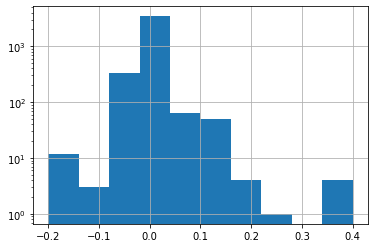

In [46]:
all_df["DIFF-Lead"].hist(log=True)

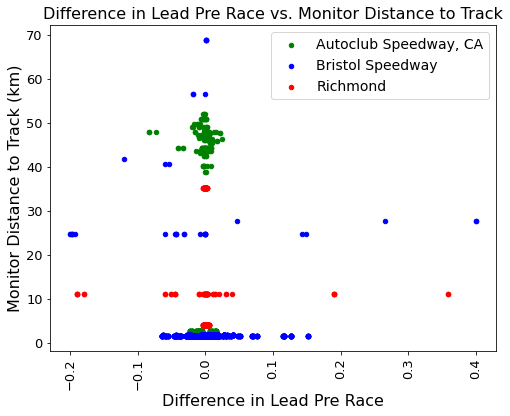

In [47]:
fig, ax = plt.subplots(figsize=(8,6))

colors = {"rich":"red",
          "auto":"green",
          "bris":"blue"}

for name, df in all_df.groupby("Track"):
    df.plot(x="DIFF-Lead", y="pre_distance_km_mean", kind="scatter", label=name, color=colors[name[:4].lower()], ax=ax)

plt.title("Difference in Lead Pre Race vs. Monitor Distance to Track", fontsize=16)
plt.xlabel('Difference in Lead Pre Race', fontsize=16)
plt.ylabel('Monitor Distance to Track (km)', fontsize=16)
plt.xticks(rotation=90)

ax.tick_params(axis='both', which='major', labelsize=13)

plt.legend(fontsize=14, frameon=True)

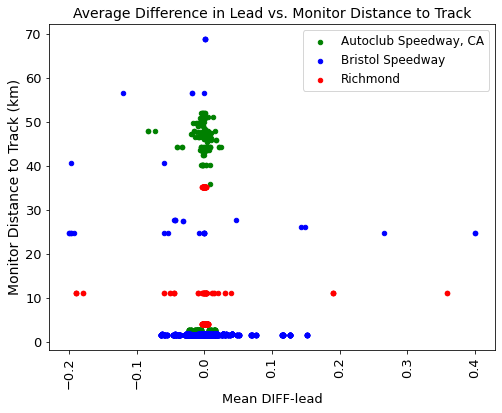

In [48]:
fig, ax = plt.subplots(figsize=(8,6))

colors = {"rich":"red",
          "auto":"green",
          "bris":"blue"}

for name, df in all_df.groupby("Track"):
    df.plot(x="DIFF-Lead", y="post_distance_km_mean", kind="scatter", label=name, color=colors[name[:4].lower()], ax=ax)

plt.title("Average Difference in Lead vs. Monitor Distance to Track", fontsize=14)
plt.xlabel('Mean DIFF-lead', fontsize=13)
plt.ylabel('Monitor Distance to Track (km)', fontsize=14)
plt.xticks(rotation=90)

ax.tick_params(axis='both', which='major', labelsize=13)

plt.legend(fontsize=12, frameon=True)

### Monitor-Year Frame With All Columns From Track Data

In [49]:
out_dfs = []

In [50]:
def get_yearly_readings(ID, distance, coord):
    id_frame = (daily_lead_df[daily_lead_df['monitorID']==ID].groupby(['year'])['monitorID'].value_counts().to_frame()
                                                   .rename(columns={'monitorID': 'readings'}).reset_index())
    id_frame['dist_from_track'] = distance
    lat, long = coord
    id_frame['monitor_lat'] = lat
    id_frame['monitor_long'] = long
    return id_frame

In [51]:
for i in range(len(stations_50mi_df)):
    row = stations_50mi_df.iloc[[i]]
    id_list = stations_50mi_df['ids'].iloc[i]
    dis_list = stations_50mi_df['distances'].iloc[i]
    points_list = stations_50mi_df['points_within_50mi'].iloc[i]
    
    for (ID, distance, coord) in zip(id_list, dis_list, points_list):
    
        each_id = get_yearly_readings(ID, distance, coord)
        repeat_tracks = pd.concat([row]*(len(each_id)), ignore_index=True)
        concat_with_ids = pd.concat([each_id, repeat_tracks], axis=1)
        out_dfs.append(concat_with_ids)

In [52]:
out_df_extra_cols = pd.concat(out_dfs)

In [53]:
monitor_year_track = (out_df_extra_cols.drop(columns=['point', 'points_within_50mi', 'ids', 
                     'distances', 'num_stations', 'mean (mi)','std (mi)',
                     'max_dist (mi)', 'max_dist (mi)', 'min_dist (mi)']).reset_index(drop=True))

In [54]:
monitor_year_track.head()

,year,monitorID,readings,dist_from_track,monitor_lat,monitor_long,obs,TrackID,State,City,lat,long,lat_Google_Maps,long_Google_Maps,track name,H_R,NASCAR_truck,NASCAR,ARCA
0,1981,340,30,30.6878,34.011208,-86.057472,0,AL-1,AL,Talladega,33.564929,-86.066571,33.567117,-86.066168,Talladega Superspeedway - Alabama Internationa...,1,1,1,1
1,1982,340,30,30.6878,34.011208,-86.057472,0,AL-1,AL,Talladega,33.564929,-86.066571,33.567117,-86.066168,Talladega Superspeedway - Alabama Internationa...,1,1,1,1
2,1983,340,26,30.6878,34.011208,-86.057472,0,AL-1,AL,Talladega,33.564929,-86.066571,33.567117,-86.066168,Talladega Superspeedway - Alabama Internationa...,1,1,1,1
3,1984,340,27,30.6878,34.011208,-86.057472,0,AL-1,AL,Talladega,33.564929,-86.066571,33.567117,-86.066168,Talladega Superspeedway - Alabama Internationa...,1,1,1,1
4,1985,340,25,30.6878,34.011208,-86.057472,0,AL-1,AL,Talladega,33.564929,-86.066571,33.567117,-86.066168,Talladega Superspeedway - Alabama Internationa...,1,1,1,1
